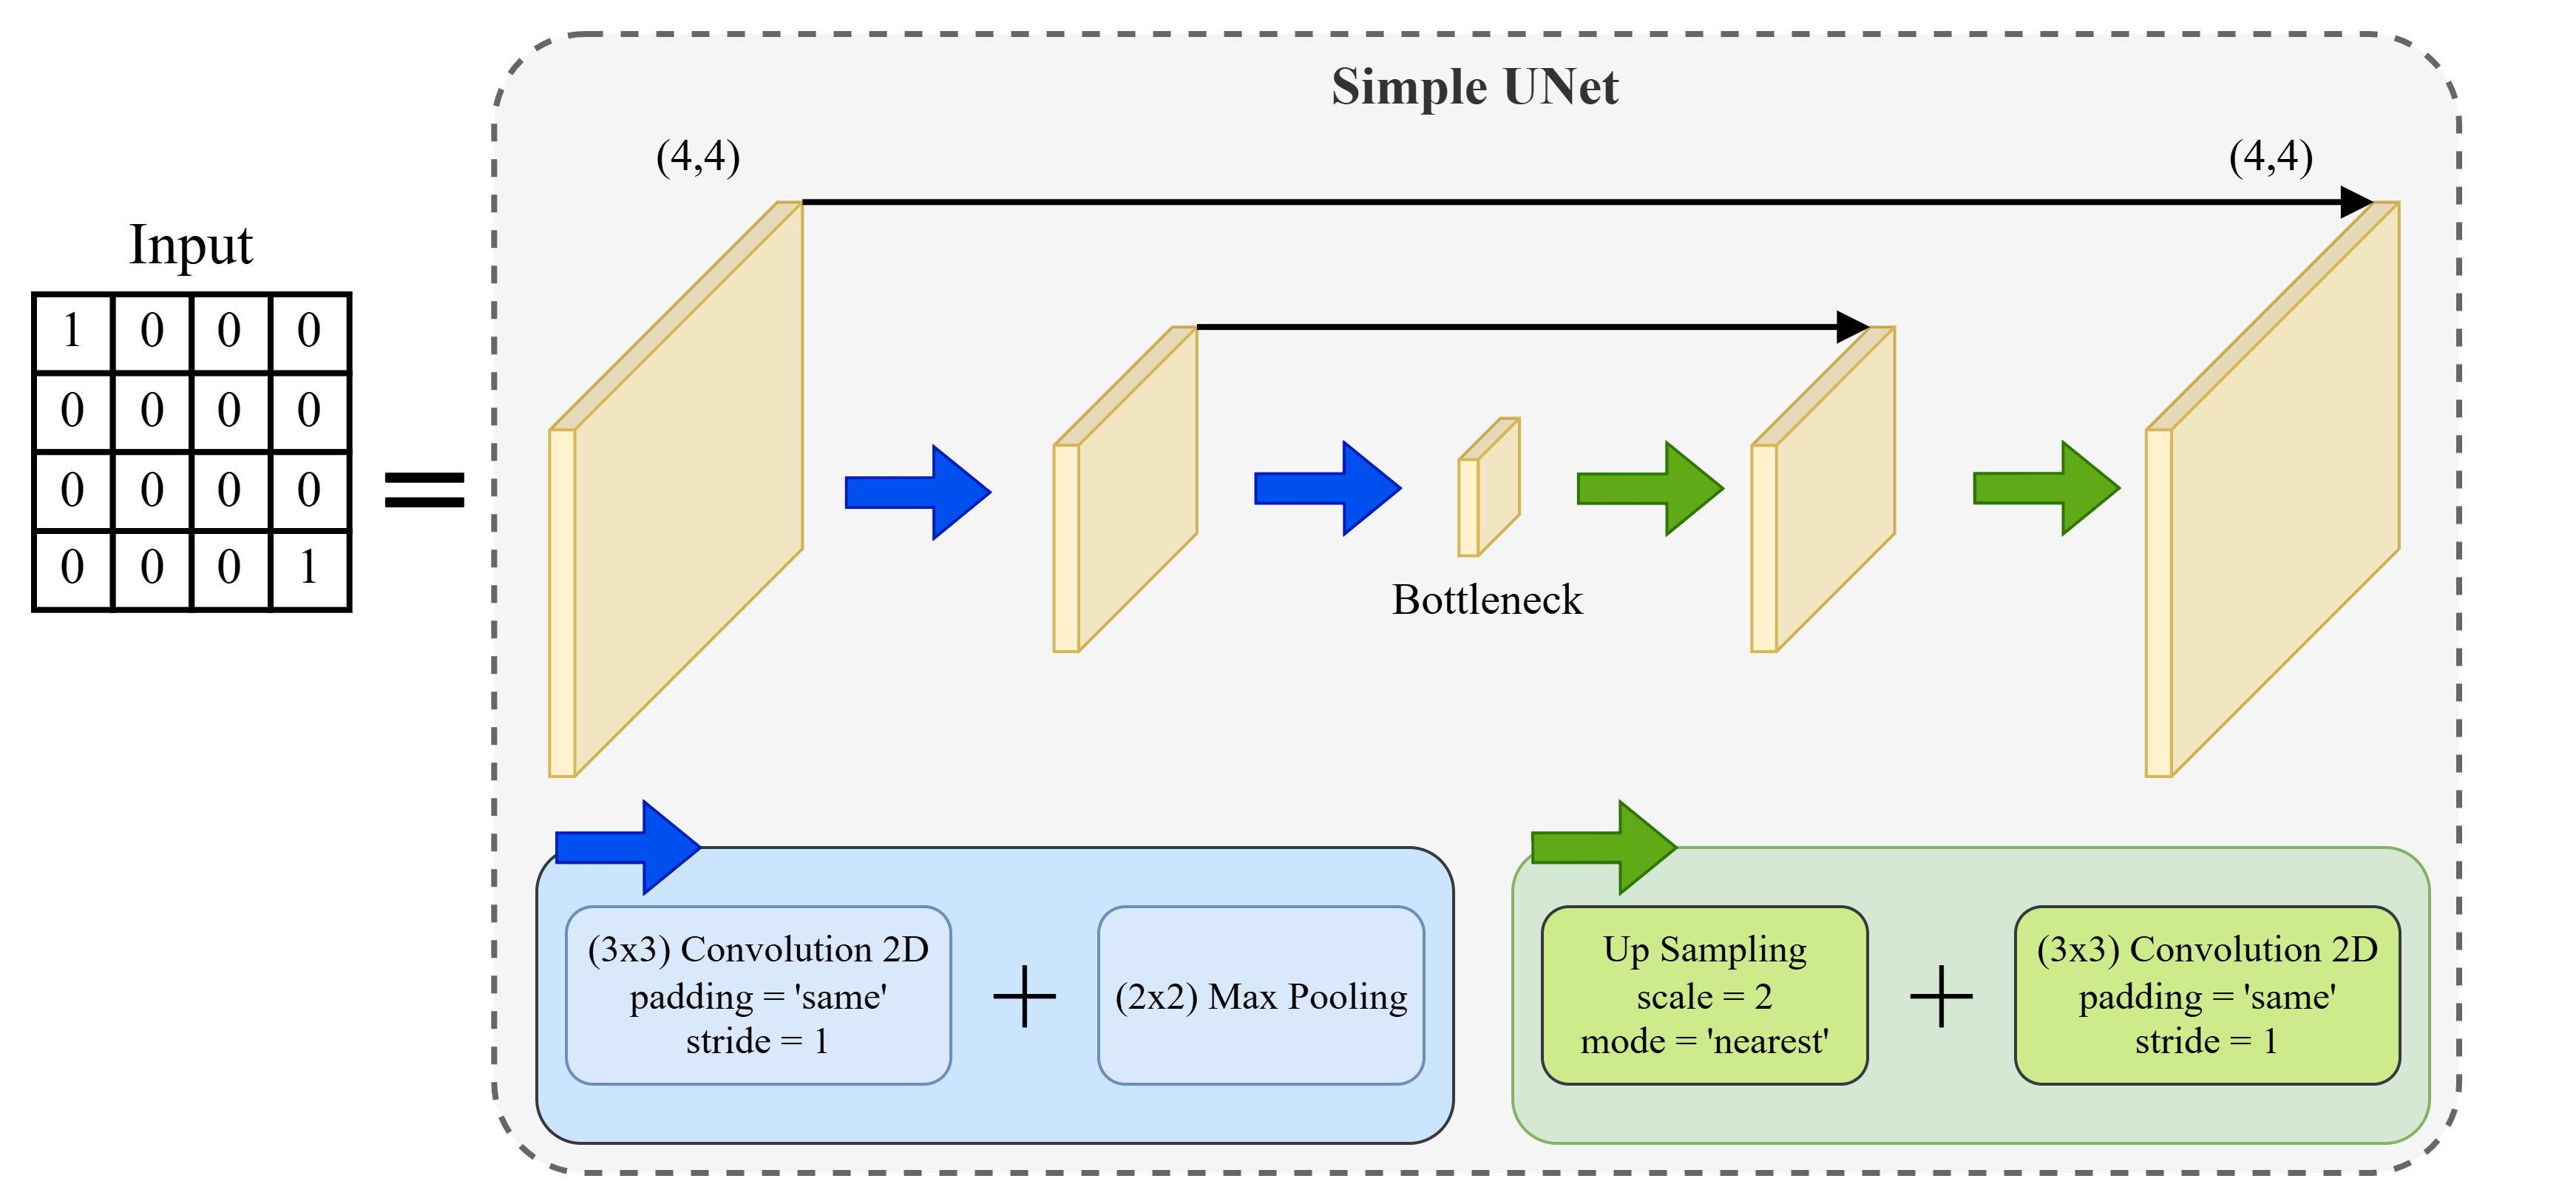

## Đề bài

Như hình trên mô tả, chúng ta có đầu vào là một ma trận 4x4 và một mạng U-Net phiên bản đơn giản với kiến trúc như sau:

1. **Encoder:**

Gồm 2 bước down-sampling:

- **Conv1**: kernel `3x3`, `padding='same'`, toàn bộ trọng số = 1, không dùng bias
- **Max Pooling**: kernel 2x2, stride=2

- **Conv2**: kernel `3x3`, `padding='same'`, toàn bộ trọng số = 1, không dùng bias
- **Max Pooling**: kernel 2x2, stride=2

Kết quả cuối cùng của bước này là **bottleneck**.

2. **Decoder:**

Gồm 2 bước up-sampling:

   - **Upsampling 1**: `scale=2`, `mode='nearest'`
   - **Conv3**: kernel `3x3`, `padding='same'`, toàn bộ trọng số = 1, không dùng bias
   - **Skip Connection 1**: cộng với đầu ra của Conv2

   - **Upsampling 2**: `scale=2`, `mode='nearest'`
   - **Conv4**: kernel `3x3`, `padding='same'`, toàn bộ trọng số = 1, không dùng bias
   - **Skip Connection 2**: cộng với đầu ra của Conv1


   Đầu ra cuối cùng (4x4) là **output** của Conv4.

**Lưu ý**: Các lớp convolution trong bài này đều dùng kernel `3x3` chứa toàn bộ trọng số bằng 1, không có bias, input và output đều có chiều sâu là 1.

## M08UNET01
### Câu hỏi: Bạn hãy thực hiện tính toán quá trình inference của mạng với input ma trận như trên. Tính ma trận **bottleneck** sau khi thực hiện 2 lần down-sampling.

**Đáp án:** B

A. `[[2], [2]]`

B. `[[2]]`

C .`[[2., 2.], [2., 2.]]`

D. `[[4]]`

## M08UNET02
### Câu hỏi: Tính **output cuối cùng** của mạng.

**Đáp án:** A

A.

```
  [[41, 61, 60, 40],
   [61, 91, 90, 60],
   [60, 90, 91, 61],
   [40, 60, 61, 41]]
```

B.

```
  [[40, 60, 60, 40],
   [60, 90, 90, 60],
   [60, 90, 90, 60],
   [40, 60, 60, 40]]
```

C.

```
  [[91, 91, 91, 91],
   [91, 91, 91, 91],
   [91, 91, 91, 91],
   [91, 91, 91, 91]]
```

D.

```
  [[11, 11, 10, 10],
   [11, 11, 10, 10],
   [10, 10, 11, 11],
   [10, 10, 11, 11]]
```


## Code for validation

In [ ]:
import torch
import torch.nn as nn

class SimpleUNet(nn.Module):
    def __init__(self):
        super(SimpleUNet, self).__init__()
        # Định nghĩa các lớp convolution với kernel 3x3, padding=1, không dùng bias.
        self.conv1 = nn.Conv2d(1, 1, kernel_size=3, padding=1, bias=False)
        self.conv2 = nn.Conv2d(1, 1, kernel_size=3, padding=1, bias=False)
        # Các conv trong decoder sẽ được đặt sau upsampling
        self.conv3 = nn.Conv2d(1, 1, kernel_size=3, padding=1, bias=False)
        self.conv4 = nn.Conv2d(1, 1, kernel_size=3, padding=1, bias=False)

        # Khởi tạo trọng số cho các lớp convolution: tất cả bằng 1.
        for conv in [self.conv1, self.conv2, self.conv3, self.conv4]:
            nn.init.constant_(conv.weight, 1)

        # Định nghĩa các lớp pooling và upsampling.
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.upsample = nn.Upsample(scale_factor=2, mode='nearest')

    def forward(self, x):
        outputs = {}

        # Encoder
        out_conv1 = self.conv1(x)          # Kích thước: 4x4
        outputs['conv1'] = out_conv1       # Skip connection từ conv1

        out_pool1 = self.pool(out_conv1)   # 4x4 -> 2x2
        outputs['down1'] = out_pool1

        out_conv2 = self.conv2(out_pool1)  # 2x2 (giữ nguyên kích thước)
        outputs['conv2'] = out_conv2       # Skip connection từ conv2

        bottleneck = self.pool(out_conv2)  # 2x2 -> 1x1
        outputs['bottleneck'] = bottleneck

        # Decoder
        # Bước 1: Upsample bottleneck, sau đó conv và mới skip với conv2
        up1 = self.upsample(bottleneck)           # 1x1 -> 2x2
        outputs['up1'] = up1
        conv_after_up1 = self.conv3(up1)            # conv sau upsampling (2x2)
        outputs['conv_after_up1'] = conv_after_up1
        merge1 = conv_after_up1 + out_conv2         # Skip connection từ conv2
        outputs['merge1'] = merge1

        # Bước 2: Upsample merge1, sau đó conv và mới skip với conv1
        up2 = self.upsample(merge1)                # 2x2 -> 4x4
        outputs['up2'] = up2
        conv_after_up2 = self.conv4(up2)             # conv sau upsampling (4x4)
        outputs['conv_after_up2'] = conv_after_up2
        merge2 = conv_after_up2 + out_conv1          # Skip connection từ conv1
        outputs['merge2'] = merge2

        # Output cuối cùng
        outputs['final'] = merge2

        return outputs

# Khởi tạo ma trận đầu vào 4x4
input_matrix = torch.tensor([[1, 0, 0, 0],
                             [0, 0, 0, 0],
                             [0, 0, 0, 0],
                             [0, 0, 0, 1]], dtype=torch.float32)
# Chuyển về dạng tensor 4D: [batch_size, channels, height, width]
input_tensor = input_matrix.unsqueeze(0).unsqueeze(0)

# Khởi tạo mô hình và chạy forward
model = SimpleUNet()
outputs = model(input_tensor)


print("Input:")
print(input_tensor.squeeze(0).squeeze(0))
# In ra kết quả của từng lớp và shape tương ứng
for layer_name, output in outputs.items():
    print(f"{layer_name}:")
    print(output.squeeze(0).squeeze(0))
    print("-"*40)


Input:
tensor([[1., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 1.]])
conv1:
tensor([[1., 1., 0., 0.],
        [1., 1., 0., 0.],
        [0., 0., 1., 1.],
        [0., 0., 1., 1.]], grad_fn=<SqueezeBackward1>)
----------------------------------------
down1:
tensor([[1., 0.],
        [0., 1.]], grad_fn=<SqueezeBackward1>)
----------------------------------------
conv2:
tensor([[2., 2.],
        [2., 2.]], grad_fn=<SqueezeBackward1>)
----------------------------------------
bottleneck:
tensor([[2.]], grad_fn=<SqueezeBackward1>)
----------------------------------------
up1:
tensor([[2., 2.],
        [2., 2.]], grad_fn=<SqueezeBackward1>)
----------------------------------------
conv_after_up1:
tensor([[8., 8.],
        [8., 8.]], grad_fn=<SqueezeBackward1>)
----------------------------------------
merge1:
tensor([[10., 10.],
        [10., 10.]], grad_fn=<SqueezeBackward1>)
----------------------------------------
up2:
tensor([[10., 10., 10., 10.],